<h1 align="center">МЧС: прогнозирование степени пожароопасности</h1>

![](https://habrastorage.org/webt/hw/ov/mm/hwovmmzc0n6y59iamjoa11zvce0.jpeg)

---

> **ЗАДАЧА:** разработать алгоритм, выдающий прогноз возникновения пожара (0 или 1) на 1, 2, 3, 4, 5, 6, 7 и 8 дней вперёд для заданной ячейки на определённую дату.  
> - ссылка задачи на [github Sber AI](https://github.com/sberbank-ai/no_fire_with_ai_aij2021)

---

<h1 align="center">Оглавление</h1>

- [1. Загрузка данных](#part1) <br>
    - [1.1 Климатические данные](#part1.1) <br>
    - [1.2 Таргеты](#part1.2) <br>
    - [1.3 OpenStreetMap](#part1.3) <br>
- [2. Генерация признаков](#part2) <br>
    - [2.1 Pooling features](#part2.1) <br>
    - [2.2 Categorical признаки даты](#part2.2) <br>
    - [2.3 Гео признаки](#part2.3) <br>
- [3. Обучение моделей](#part3) <br>
    - [3.1 Многоклассовая классификация](#part3.1) <br>
    - [3.2 Модель для каждого таргета](#part3.2) <br>
- [4. sample_submission.zip](#part4) <br>
- [5. Метрика соревнования](#part5) <br>

---

<h1 align="center">0. Импорт необходимых библиотек</h1>

> **NOTE**: Для некоторых библиотек потребуется установка дополнительных зависимостей. Более детальную информацию вы сможете найти в нашем **Dockerfile** и **requirements.txt**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%ls
%cd drive/MyDrive/Datasets
!git clone https://github.com/sberbank-ai/no_fire_with_ai_aij2021

Mounted at /content/drive
drive/  sample_data/
/content/drive/MyDrive/Datasets
fatal: destination path 'no_fire_with_ai_aij2021' already exists and is not an empty directory.


In [ ]:
%cd no_fire_with_ai_aij2021
!ls

/content/drive/My Drive/Datasets/no_fire_with_ai_aij2021
Baseline.ipynb		metadata.json	  requirements.txt
Dockerfile		prepare_train.py  sample_submission.zip
features_generation.py	preprocessing.py  sbercloud_instruction_en.md
helpers.py		readme_en.md	  sbercloud_instruction.md
input			README.md	  solution.py


In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 69.2 MB 5.9 kB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 994 kB 69.9 MB/s 
     |████████████████████████████████| 22.3 MB 80.0 MB/s 
     |████████████████████████████████| 827 kB 60.7 MB/s 
     |████████████████████████████████| 12.1 MB 12.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 602 kB 66.6 MB/s 
     |████████████████████████████████| 59 kB 7.4 MB/s 
     |████████████████████████████████| 6.3 MB 43.0 MB/s 
     |████████████████████████████████| 15.4 MB 40 kB/s 
     |████████████████████████████████| 219 kB 50.9 MB/s 
     |████████████████████████████████| 214 kB 70.2 MB/s 
  Created wheel for Cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516196 sha256=af52d5899e13c0f97357f85d8b0bfea70d56a4f89be1b931687300d360a62a10
  Stored

In [ ]:
!pip install eccodes==1.2.0
!sudo apt-get install libeccodes-tools

     |████████████████████████████████| 46 kB 2.1 MB/s 
  Attempting uninstall: eccodes
    Found existing installation: eccodes 1.3.3
    Uninstalling eccodes-1.3.3:
      Successfully uninstalled eccodes-1.3.3
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  ed libeccodes-data libeccodes0 mksh
The following NEW packages will be installed:
  ed libeccodes-data libeccodes-tools libeccodes0 mksh
0 upgraded, 5 newly installed, 0 to remove and 37 not upgraded.
Need to get 3,661 kB of archives.
After this operation, 81.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 ed amd64 1.10-2.1 [49.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libeccodes-data all 2.6.0-2 [1,260 kB]
Get:3 ht

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import cfgrib
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostClassifier
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass


# модули из репозитория https://github.com/sberbank-ai/no_fire_with_ai_aij2021
import helpers, preprocessing, features_generation, prepare_train
from solution import FEATURES

import warnings
warnings.simplefilter("ignore")
plt.rcParams["figure.figsize"] = (16,8)

---

<a id='part1'></a>
<h1 align="center">1. Загрузка данных</h1>

> **NOTE**: Для воспроизводимости бейзлайна, проверьте наличие файлов по пути **input/**:
```
├── city_town_village.geojson
├── ERA5_data
│   ├── evaporation1_2020.grib
│   ├── evaporation1_2021.grib
│   ├── evaporation2_2020.grib
│   ├── evaporation2_2021.grib
│   ├── heat1_2020.grib
│   ├── heat1_2021.grib
│   ├── heat2_2020.grib
│   ├── heat2_2021.grib
│   ├── temp_2018.grib
│   ├── temp_2020.grib
│   ├── temp_2021.grib
│   ├── vegetation_2020.grib
│   ├── vegetation_2021.grib
│   ├── wind_2020.grib
│   └── wind_2021.grib
├── train.csv
├── train_raw.csv
└── sample_test.csv
```

In [ ]:
!ls


Baseline.ipynb		prepare_train.py  sample_submission.zip
Dockerfile		preprocessing.py  sbercloud_instruction_en.md
features_generation.py	__pycache__	  sbercloud_instruction.md
helpers.py		readme_en.md	  solution.py
input			README.md
metadata.json		requirements.txt


/content/drive/MyDrive/Datasets/no_fire_with_ai_aij2021


<a id='part1.1'></a>
<h2 align="center">1.1 Климатические данные</h2>

### Пример работы с файлом `.grib`

In [ ]:
ds = cfgrib.open_datasets('input/ERA5_data/temp_2018.grib')

2021-11-02,07:26:02 Ignoring index file '/content/drive/My Drive/Datasets/no_fire_with_ai_aij2021/input/ERA5_data/temp_2018.grib.923a8.idx' incompatible with GRIB file
2021-11-02,07:26:07 Ignoring index file '/content/drive/MyDrive/Datasets/no_fire_with_ai_aij2021/input/ERA5_data/temp_2018.grib.923a8.idx' incompatible with GRIB file
2021-11-02,07:26:11 Ignoring index file '/content/drive/MyDrive/Datasets/no_fire_with_ai_aij2021/input/ERA5_data/temp_2018.grib.923a8.idx' incompatible with GRIB file
2021-11-02,07:26:15 Ignoring index file '/content/drive/MyDrive/Datasets/no_fire_with_ai_aij2021/input/ERA5_data/temp_2018.grib.923a8.idx' incompatible with GRIB file


In [ ]:
len(ds)

3

Файл представляет из себя несколько объектов формата `xarray.Dataset`, например, файл `temp_2018.grib` состоит из 3 объектов. Объекты содержат значения признаков для трех измерений **(latitude: 406, longitude: 1501, time: 365)**:
- Первый объект содержит следующий набор признаков:
    - stl1: Soil temperature level 1
- Второй объект содержит:
    - t2m: 2 metre temperature
    - d2m: 2 metre dewpoint temperature
- Третий объект содержит:
    - skt: Skin temperature

> **NOTE**: Данные признаки являются измерениями на определенную дату, в определенной широте и долготе, частота признаков 0.1 градус

In [ ]:
ds[0].indexes['time'].min(), ds[0].indexes['time'].max()

(Timestamp('2018-01-01 14:00:00'), Timestamp('2018-12-31 14:00:00'))

In [ ]:
ds[2]

<xarray.Dataset>
Dimensions:     (time: 365, latitude: 406, longitude: 1501)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2018-01-01T14:00:00 ... 2018-12-31T14:0...
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 81.5 81.4 81.3 81.2 ... 41.3 41.2 41.1 41.0
  * longitude   (longitude) float64 19.0 19.1 19.2 19.3 ... 168.8 168.9 169.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    skt         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

### Визуализация объекта `xarray.Dataset`

Очень хорошо видны очертания России 🇷🇺

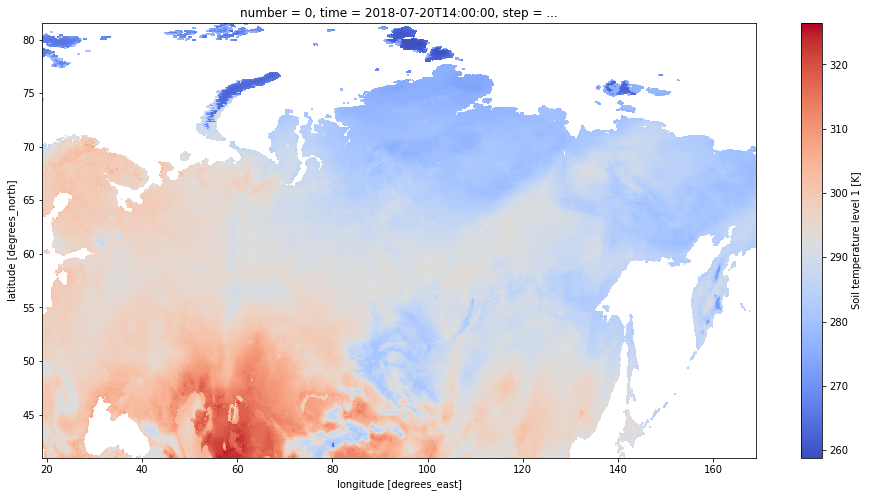

In [ ]:
ds[0].stl1[200].plot(cmap=plt.cm.coolwarm);

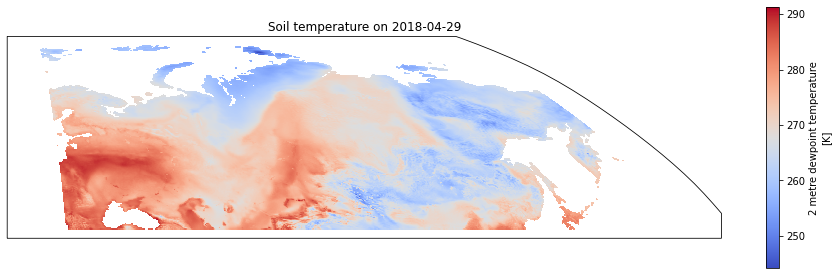

In [ ]:
# Может понадобиться выполнение команд
# pip uninstall shapely
# pip install shapely --no-binary shapely

ax = plt.axes(projection=ccrs.Robinson())
# ax.coastlines(resolution='10m')
plot = ds[1].d2m[119].plot(cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.6})
plt.title('Soil temperature on 2018-04-29');

### Парсим куб из `xarray.Dataset` из файла `temp_2018.grib`

Для дальнейшей работы с климатическими признаками, можно парсить объекты `xarray.Dataset`, например, функциями `parse_dims` и `parse_cube`

> **NOTE**: 
> - Результат работы функции `parse_cube`: `словарь` ключ - название признака, значение - **3-мерный numpy массив** (день, ширина, долгота)
> - Результат работы функции `parse_dims`: **1-мерные массивы** с информацией о значениях осей 3-мерного массива.

In [ ]:
times, latitudes, longitudes = preprocessing.parse_dims(ds)

Наблюдаем, что широта отсортирована по убыванию, что не естественно для матричного представления, учтем это

In [ ]:
latitudes

Float64Index([              81.5,               81.4,  81.30000000000001,
               81.20000000000002,  81.10000000000002,  81.00000000000003,
               80.90000000000003,  80.80000000000004,  80.70000000000005,
               80.60000000000005,
              ...
               41.90000000000068,  41.80000000000068,  41.70000000000068,
              41.600000000000676, 41.500000000000675, 41.400000000000674,
               41.30000000000067,  41.20000000000067,  41.10000000000067,
               41.00000000000067],
             dtype='float64', name='latitude', length=406)

In [ ]:
longitudes

Float64Index([              19.0,               19.1, 19.200000000000003,
              19.300000000000004, 19.400000000000006, 19.500000000000007,
               19.60000000000001,  19.70000000000001,  19.80000000000001,
              19.900000000000013,
              ...
              168.09999999999474, 168.19999999999473, 168.29999999999472,
              168.39999999999472,  168.4999999999947,  168.5999999999947,
               168.6999999999947,  168.7999999999947,  168.8999999999947,
              168.99999999999469],
             dtype='float64', name='longitude', length=1501)

<a id='part1.2'></a>
<h2 align="center">1.2 Таргеты</h2>

### Загружаем таргеты

####  `train_raw.csv`
Сырой датасет для обучения моделей.
- **dt** - Текущая дата наблюдения;
- **lon** - Координата конкретной точки пожара - `долготы`;
- **lat** - Координата конкретной точки пожара - `широты`;
- **type_id** - Код типа пожара;
- **type_name** - Наименование типа пожара;

In [ ]:
train_raw = pd.read_csv('input/train_raw.csv', parse_dates=['dt'])
print(train_raw.shape)
train_raw.head()

(547763, 5)


dt         lon        lat  type_id        type_name
0 2012-03-13  131.586613  47.866183        4  Природный пожар
1 2012-03-13  131.588507  47.880940        4  Природный пожар
2 2012-03-13  131.987129  48.497325        3     Лесной пожар
3 2012-03-13  131.903087  43.627665        4  Природный пожар
4 2012-03-13  131.570614  47.858103        4  Природный пожар

In [ ]:
train_raw.dt.min(), train_raw.dt.max()

(Timestamp('2012-03-13 00:00:00'), Timestamp('2021-04-22 00:00:00'))

####  `train.csv`
Подготовленный датасет для обучения моделей. Получен с помощью функции `prepare_train.make_train` из сырого датасета для обучения.
- **dt** - Текущая дата наблюдения;
- **lon_min** - Нижняя граница ячейки наблюдения по `долготе`;
- **lat_min** - Нижняя граница ячейки наблюдения по `широте`;
- **lon_max** - Верхняя граница ячейки наблюдения по `долготе`;
- **lat_max** - Верхняя граница ячейки наблюдения по `широте`;
- **lon** - Координата конкретной точки пожара - `долготы` **(при наличии)**;
- **lat** - Координата конкретной точки пожара - `широты` **(при наличии)**;
- **grid_index** - Индекс ячейки **(подробности ниже)**;
- **type_id** - Код типа пожара **(при наличии)**;
- **type_name** - Наименование типа пожара **(при наличии)**;
- **is_land** - Метка того, был ли пожар на этой ячейке за всю историю (суша или нет);
--------------
- **infire_day_1** - `Целевая переменная` вероятность пожара на следующий день;
- **infire_day_2** - `Целевая переменная` вероятность пожара через 2 дня;
- **infire_day_3** - `Целевая переменная` вероятность пожара через 3 дня;
- **infire_day_4** - `Целевая переменная` вероятность пожара через 4 дня;
- **infire_day_5** - `Целевая переменная` вероятность пожара через 5 дней;
- **infire_day_6** - `Целевая переменная` вероятность пожара через 6 дней;
- **infire_day_7** - `Целевая переменная` вероятность пожара через 7 дней;
- **infire_day_8** - `Целевая переменная` вероятность пожара через 8 дней;

> **NOTE**:
> - Размер ячейки 0.2 x 0.2 широты - долготы
> - В рамках этого бейзлайна, выбираем данные для обучения **только** с 2020 года

Для удобства добавления признаков к нашим наблюдениям можно использовать `grid_index`, который заменит границы ячейки одним числом, которое вычисляется по простой формуле:

$$\mathcal grid\_index = row_i * col_n + col_i,$$  
в нашем случае всего столбцов (`col_n`) - **750**, всего строк - **203**.

> **NOTE**: В качестве начальных значений для индексации будем использовать **минимальные** значения ширины и долготы в файлах `.grib`, по той причине - потому что они меньше, чем минимальные значения в таргетах

![](https://habrastorage.org/webt/ji/cf/js/jicfjs3yfotvsvwxsp85eqifxtq.jpeg)

In [ ]:
lat_min = round(latitudes.min(), 1)
lat_max = round(latitudes.max(), 1)

lon_min = round(longitudes.min(), 1)
lon_max = round(longitudes.max(), 1)

lat_min, lat_max, lon_min, lon_max

(41.0, 81.5, 19.0, 169.0)

In [ ]:
step = 0.2
array_of_lats = np.arange(lat_min, lat_max, step).round(1)
array_of_lons = np.arange(lon_min, lon_max, step).round(1)
print(len(array_of_lats), len(array_of_lons))

203 750


In [ ]:
#train = prepare_train.make_train('input/train_raw.csv',
#                                  array_of_lons, array_of_lats, step,
#                                  start_date='2020-01-01')
train = pd.read_csv('input/train.csv', parse_dates=['dt'])
print(train.shape)
train.head()

(488103, 19)


dt  lon_min  lat_min  ...  infire_day_6  infire_day_7  infire_day_8
0 2020-05-04     47.6     41.0  ...             0             0             0
1 2021-02-24     47.2     41.2  ...             0             0             0
2 2021-02-27     47.2     41.2  ...             0             0             0
3 2021-04-01     47.4     41.2  ...             0             0             0
4 2020-03-14     47.6     41.2  ...             0             0             0

[5 rows x 19 columns]

In [ ]:
train.dt.min(), train.dt.max()

(Timestamp('2020-01-01 00:00:00'), Timestamp('2021-04-22 00:00:00'))

####  `sample_test.csv`
Пример датасета для создания паблик-лидерборда.
- **id** - Id строки для оценки предсказаний;
- **dt** - Текущая дата наблюдения;
- **lon_min** - Нижняя граница ячейки наблюдения по `долготе`;
- **lat_min** - Нижняя граница ячейки наблюдения по `широте`;
- **lon_max** - Верхняя граница ячейки наблюдения по `долготе`;
- **lat_max** - Верхняя граница ячейки наблюдения по `широте`;
- **lon** - Координата конкретной точки пожара - `долготы` **(при наличии)**;
- **lat** - Координата конкретной точки пожара - `широты` **(при наличии)**;
- **grid_index** - Индекс ячейки;
- **type_id** - Код типа пожара **(при наличии)**;
- **type_name** - Наименование типа пожара **(при наличии)**;

In [ ]:
sample_test = pd.read_csv('input/sample_test.csv', parse_dates=['dt'])
print(sample_test.shape)
sample_test.head()

(5, 11)


id         dt  lon_min  lat_min  ...  lat  grid_index  type_id  type_name
0   0 2021-05-26     47.6     41.0  ...  NaN         143      NaN        NaN
1   1 2021-06-13     47.6     41.0  ...  NaN         143      NaN        NaN
2   2 2021-06-30     47.6     41.0  ...  NaN         143      NaN        NaN
3   3 2021-05-22     47.8     41.2  ...  NaN         894      NaN        NaN
4   4 2021-05-11     47.2     41.6  ...  NaN        2391      NaN        NaN

[5 rows x 11 columns]

### Разделим выборку `train` на `train/val` датасеты

In [ ]:
val = train[train.dt >= "2021-02-01"].reset_index(drop=True)
train = train[train.dt < "2021-02-01"].reset_index(drop=True)
train.shape, val.shape

((414455, 19), (73648, 19))

### Посмотрим на распределение таргетов:

In [ ]:
train[['infire_day_1', 'infire_day_2', 'infire_day_3',
       'infire_day_4', 'infire_day_5', 'infire_day_6',
       'infire_day_7', 'infire_day_8']].apply(pd.Series.value_counts)

infire_day_1  infire_day_2  ...  infire_day_7  infire_day_8
0        362251        362248  ...        362223        362219
1         52204         52207  ...         52232         52236

[2 rows x 8 columns]

In [ ]:
val[['infire_day_1', 'infire_day_2', 'infire_day_3',
       'infire_day_4', 'infire_day_5', 'infire_day_6',
       'infire_day_7', 'infire_day_8']].apply(pd.Series.value_counts)

infire_day_1  infire_day_2  ...  infire_day_7  infire_day_8
0         68472         68014  ...         65406         64782
1          5176          5634  ...          8242          8866

[2 rows x 8 columns]

<a id='part1.3'></a>
<h2 align="center">1.3 OpenStreetMap</h2>

### Скачиваем информацию используя `OSMPythonTools` по ключу [Key:place](https://wiki.openstreetmap.org/wiki/Key:place)

- Обратите внимание на [Key:natural](https://wiki.openstreetmap.org/wiki/Key:natural)
- если загрузка слишком долгая, можно воспользоваться веб-сервисом `https://overpass-turbo.eu/#`, выполнить запрос, экспортировать в файл, например `.geojson`. (При обращении к api есть квота по ip)

Пример запроса к веб-сервису, который идентичен коду ниже:

```
[out:json][timeout:1000];
area(3600060189)->.searchArea;
(
  node["place"~"city|town|village"](area.searchArea);
  way["place"~"city|town|village"](area.searchArea);
  relation["place"~"city|town|village"](area.searchArea);
);
out body;
>;

```  

>**NOTE**: файл **city_town_village.geojson** получен именно таким образом

In [ ]:
nominatim = Nominatim()
areaId = nominatim.query('Россия').areaId()
areaId

2021-11-02,07:39:25 [nominatim] downloading data: search


3600060189

In [ ]:
overpass = Overpass()
query = overpassQueryBuilder(area=areaId, elementType=['node', 'way', 'relation'], selector='"place"~"city|town|village"')
result = overpass.query(query, timeout=1000)
res_json = result.toJSON()

2021-11-02,07:39:28 [overpass] downloading data: [timeout:1000][out:json];area(3600060189)->.searchArea;(node["place"~"city|town|village"](area.searchArea);way["place"~"city|town|village"](area.searchArea);relation["place"~"city|town|village"](area.searchArea);); out body;


In [ ]:
from json import dumps
with open("input/forests_chu.geojson", "w") as file:
    file.write(dumps(res_json))

### Загружаем `.geojson` в `geopandas`

Итак, мы получили файл `*.geojson` одним из двух способов, далее будем работать с ним с помощью библиотеки `geopandas`.
> **NOTE**: Для примера, выбраны не все потенциально полезные столбцы;  
Также можно учесть, что значение признака `population` было зафиксировано на определенную дату. В данном бейзлайне пренебрегаем возможным `data leakage` и не актуальным значением.

In [ ]:
forests_chu_df = gpd.read_file('input/forests_chu.geojson')
forests_chu_df

2021-11-02,07:57:45 `input/forests_chu.geojson' not recognized as a supported file format.


DriverError: ignored

In [ ]:
forests_chu_df.geometry

In [ ]:
cities_df_reserve = gpd.read_file('input/city_town_village.geojson')
cities_df_reserve

id              @id  ... alt_name:lbe                   geometry
0              node/54          node/54  ...         None  POINT (82.92345 55.02822)
1        node/26163795    node/26163795  ...         None  POINT (29.91713 56.01762)
2        node/26878551    node/26878551  ...         None  POINT (32.41306 67.15144)
3        node/26898767    node/26898767  ...         None  POINT (33.40439 67.56863)
4        node/26898768    node/26898768  ...         None  POINT (31.18017 65.20010)
...                ...              ...  ...          ...                        ...
39965  node/8942161262  node/8942161262  ...         None  POINT (31.23784 58.53382)
39966  node/8942161263  node/8942161263  ...         None  POINT (31.25000 58.54128)
39967  node/8942161264  node/8942161264  ...         None  POINT (31.24839 58.53692)
39968  node/8946589745  node/8946589745  ...         None  POINT (61.22180 55.23065)
39969  node/8948018957  node/8948018957  ...         None  POINT (61.25211 55.24691)

[39970 rows x 607 columns]

In [ ]:
cities_df = gpd.read_file('input/city_town_village.geojson')
cities_df = cities_df[['admin_level', 'name', 'population', 'population:date', 'place', 'geometry']]
cities_df = cities_df[cities_df.place != 'city_block'].reset_index(drop=True)
cities_df['lon'] = cities_df['geometry'].x
cities_df['lat'] = cities_df['geometry'].y

cities_df.loc[cities_df.lon < 0, 'lon'] += 360
cities_df.loc[cities_df.population.notna(), 'population'] = cities_df[cities_df.population.notna()]\
                            .population.apply(helpers.split_string).str.replace(" ", "").astype(int)
cities_df.head()

2021-11-02,08:14:11 NumExpr defaulting to 4 threads.


admin_level         name  ...        lon        lat
0           3  Новосибирск  ...  82.923451  55.028217
1        None       Невель  ...  29.917128  56.017616
2        None   Кандалакша  ...  32.413055  67.151442
3           6      Апатиты  ...  33.404392  67.568626
4        None     Калевала  ...  31.180172  65.200096

[5 rows x 8 columns]

### Переводим значения city_lon и city_lat к нашей сетке

Координаты центра каждого поселения переводим в рамки наших границ ячеек, как в таргетах

In [ ]:
cities_df = helpers.add_edges_polygon(cities_df)
cities_df = cities_df[(cities_df.lon_max <= lon_max) &\
                      (cities_df.lon_min >= lon_min) &\
                      (cities_df.lat_min >= lat_min) &\
                      (cities_df.lat_max <= lat_max)].reset_index(drop=True)

### Добавляем `grid_index` для городов

После того как мы добавили границы для ячейки размера 0.2 x 0.2 широты - долготы, можем добавить `grid_index`

In [ ]:
cities_df = helpers.get_grid_index(cities_df, array_of_lons, array_of_lats)

### Переименовываем для удобства

In [ ]:
cities_df.rename(columns={'lon': 'city_lon',
                          'lat': 'city_lat'}, inplace=True)
cities_df.head()

admin_level         name population  ... lat_min lat_max grid_index
0           3  Новосибирск    1625600  ...    55.0    55.2      52819
1        None       Невель      16272  ...    56.0    56.2      56304
2        None   Кандалакша      30575  ...    67.0    67.2      97567
3           6      Апатиты      55713  ...    67.4    67.6      99072
4        None     Калевала       3855  ...    65.2    65.4      90810

[5 rows x 13 columns]

---

<a id='part2'></a>
<h1 align="center">2. Генерация признаков</h1>

<a id='part2.1'></a>
<h2 align="center">2.1 Pooling features</h2>

![](https://habrastorage.org/webt/dy/w1/_k/dyw1_kokc_kch6f-d37esfptjbw.jpeg)

Так как в нашем датасете у таргетов размер ячеек 0.2 x 0.2, а у климатических признаков частота измерений 0.1, мы можем использовать либо всю матрицу 0.2 х 0.2 целиком, либо использовать `pooling` c `kernel_size` = 3 и `stride` = 2

### Считаем `pooling features`
И сразу переводим в так называемый `grid_index`, по которому в дальнейшем будем матчить с таргетами и сохраняем полученные тензоры в `additional_data/`

> **NOTE**: 
> - Так как для обучения мы взяли данные **только** с 2020 года, соответственно считаем `poolling features` также только для данных с 2020 года;  
> - Выберем все доступные признаки из климатических

In [ ]:
%%time

PATH_TO_ADD_DATA = 'additional_data/'

grib_list = [el.split('.')[0] for el in os.listdir("input/ERA5_data")\
             if el.startswith(("temp", "wind",
                               "evaporation1", "evaporation2",
                               "heat1", "heat2", "vegetation")) and el.endswith(('2020.grib', '2021.grib'))]

for file_name in grib_list:
    preprocessing.make_pool_features("input/ERA5_data",
                                     file_name, PATH_TO_ADD_DATA)

2021-11-02,08:15:26 Ignoring index file '/content/drive/My Drive/Datasets/no_fire_with_ai_aij2021/input/ERA5_data/vegetation_2020.grib.923a8.idx' incompatible with GRIB file
2021-11-02,08:15:28 Ignoring index file '/content/drive/My Drive/Datasets/no_fire_with_ai_aij2021/input/ERA5_data/vegetation_2020.grib.923a8.idx' incompatible with GRIB file
2021-11-02,08:15:54 Ignoring index file '/content/drive/My Drive/Datasets/no_fire_with_ai_aij2021/input/ERA5_data/vegetation_2021.grib.923a8.idx' incompatible with GRIB file
2021-11-02,08:15:56 Ignoring index file '/content/drive/My Drive/Datasets/no_fire_with_ai_aij2021/input/ERA5_data/vegetation_2021.grib.923a8.idx' incompatible with GRIB file
2021-11-02,08:16:33 Ignoring index file '/content/drive/My Drive/Datasets/no_fire_with_ai_aij2021/input/ERA5_data/wind_2020.grib.923a8.idx' incompatible with GRIB file
2021-11-02,08:16:37 Ignoring index file '/content/drive/My Drive/Datasets/no_fire_with_ai_aij2021/input/ERA5_data/wind_2020.grib.923a8.i

CPU times: user 5min 20s, sys: 1min, total: 6min 20s
Wall time: 8min 28s


### Добавляем признаки из подготовленного тензорного представления

In [ ]:
%%time
PATH_TO_ADD_DATA = 'additional_data/'
train = features_generation.add_pooling_features(train, PATH_TO_ADD_DATA, count_lag=3)
val = features_generation.add_pooling_features(val, PATH_TO_ADD_DATA, count_lag=3)

CPU times: user 9min 39s, sys: 19.4 s, total: 9min 58s
Wall time: 12min 47s


<a id='part2.2'></a>
<h2 align="center">2.2 Categorical признаки даты</h2>

Добавляем в качестве категориальных признаков - месяц, день месяца, неделя с начала года, день недели.

In [ ]:
train = features_generation.add_cat_date_features(train)
val = features_generation.add_cat_date_features(val)
train

dt  lon_min  lat_min  lon_max  ...  month  day  weekofyear  dayofweek
0      2020-05-04     47.6     41.0     47.8  ...      5    4          19         19
1      2020-03-14     47.6     41.2     47.8  ...      3   14          11         11
2      2020-04-22     47.6     41.2     47.8  ...      4   22          17         17
3      2020-05-20     47.6     41.2     47.8  ...      5   20          21         21
4      2020-08-26     47.6     41.2     47.8  ...      8   26          35         35
...           ...      ...      ...      ...  ...    ...  ...         ...        ...
414450 2020-12-15     95.6     81.0     95.8  ...     12   15          51         51
414451 2020-12-29     95.6     81.0     95.8  ...     12   29          53         53
414452 2020-06-06     95.8     81.0     96.0  ...      6    6          23         23
414453 2020-08-16     95.8     81.0     96.0  ...      8   16          33         33
414454 2020-05-24     96.0     81.0     96.2  ...      5   24          21         21

[414455 rows x 159 columns]

<a id='part2.3'></a>
<h2 align="center">2.3 Гео признаки</h2>

****Добавляем признаки полученные из `OpenStreetMap`****:
- **distance_to_nearest_city** - расстояние до ближайшего населенного пункта;
- **place** - тип населенного пункта;
- **population** - численность населения

In [ ]:
%%time
train = features_generation.add_geo_features(train, cities_df)
val = features_generation.add_geo_features(val, cities_df)

CPU times: user 34.4 s, sys: 828 ms, total: 35.2 s
Wall time: 35.2 s


In [ ]:
def fill_mean_nan(feat, feat_name):
  feat = feat.fillna((train['{}_min'.format(feat_name)] + train['{}_max'.format(feat_name)]) / 2)
  return feat

In [ ]:

train

dt  lon_min  ...   city_lat  distance_to_nearest_city
0      2020-05-04     47.6  ...  41.283037                  0.226849
1      2020-03-14     47.6  ...  41.380943                  0.000000
2      2020-04-22     47.6  ...  41.380943                  0.000000
3      2020-05-20     47.6  ...  41.380943                  0.000000
4      2020-08-26     47.6  ...  41.380943                  0.000000
...           ...      ...  ...        ...                       ...
414450 2020-12-15     95.6  ...        NaN                       NaN
414451 2020-12-29     95.6  ...        NaN                       NaN
414452 2020-06-06     95.8  ...        NaN                       NaN
414453 2020-08-16     95.8  ...        NaN                       NaN
414454 2020-05-24     96.0  ...        NaN                       NaN

[414455 rows x 166 columns]

In [ ]:
train.lon = fill_mean_nan(train.lon, "lon")
val.lon = fill_mean_nan(val.lon, "lon")
train.lat = fill_mean_nan(train.lat, "lat")
val.lat = fill_mean_nan(val.lat, "lat")

In [ ]:
counter = 0
for i, row in val.iterrows():
  if np.isnan(row.lon):
    counter += 1
print(counter)


0


In [ ]:
val.lon.isna().sum()

0

In [ ]:
train

dt  lon_min  ...   city_lat  distance_to_nearest_city
0      2020-05-04     47.6  ...  41.283037                  0.226849
1      2020-03-14     47.6  ...  41.380943                  0.000000
2      2020-04-22     47.6  ...  41.380943                  0.000000
3      2020-05-20     47.6  ...  41.380943                  0.000000
4      2020-08-26     47.6  ...  41.380943                  0.000000
...           ...      ...  ...        ...                       ...
414450 2020-12-15     95.6  ...        NaN                       NaN
414451 2020-12-29     95.6  ...        NaN                       NaN
414452 2020-06-06     95.8  ...        NaN                       NaN
414453 2020-08-16     95.8  ...        NaN                       NaN
414454 2020-05-24     96.0  ...        NaN                       NaN

[414455 rows x 230 columns]

---

<a id='part3'></a>
<h1 align="center">3. Обучение моделей</h1>

Итак, наш датасет готов, можем приступать к обучению.  
В качестве бейзлайна выбрана модель `CatBoostClassifier`.
> **NOTE**: 
> - для каждого из таргетов будем обучать классификатор отдельно
> - мы не прогнозируем как быстро пожар будут тушить, это зависит от многих факторов и не является приоритетным для данной задачи, поэтому изменим таргеты, так же, как и при расчете метрики, подробности в `README.MD`
> - добавим девятую модель - многоклассовую классификацию для предсказания начала пожара, с помощью этой модели будем модифицировать наши предсказания/или же только ее использовать для предсказаний

In [ ]:
cat_features = ['month', 'day', 'weekofyear', 'dayofweek', 'place']
cat_features = train[FEATURES].columns.intersection(cat_features)
cat_features = [train[FEATURES].columns.get_loc(feat) for feat in cat_features]
cat_features

KeyError: ignored

<a id='part3.1'></a>
<h2 align="center">3.1 Многоклассовая классификация</h2>

#### Создадим таргет - через какое количество дней начнется пожар

In [ ]:
def get_multiclass_target(df):
    df = df.copy()
    for i in range(8, 0, -1):
        df.loc[df[f'infire_day_{i}'] == 1, 'multiclass'] = i
    df.fillna(0, inplace=True)
    return df.multiclass

In [ ]:
train_targets = train.iloc[:,11:11+8]
val_targets = val.iloc[:,11:11+8]

train_target_mc = get_multiclass_target(train_targets)
val_target_mc = get_multiclass_target(val_targets)

### Кореляция фичей

Так как в датасете было очень много nan-значений решил для начала заменить их на средние по столбцу

In [ ]:
train.loc[:, train.dtypes != 'object'].fillna(train.loc[:, train.dtypes != 'object'].mean())

((414455, 161), (414455, 166))

In [ ]:
corr = train.loc[:, train.dtypes != 'object'].fillna(train.loc[:, train.dtypes != 'object'].mean()).corr()

In [ ]:
short_corr = corr[corr > 0.7]
short_corr.style.background_gradient(cmap='coolwarm' )

### Поиск оптимальных параметров CatBoostClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


У нас есть не все FEATURES, поэтому пришлос закостылить свои)

In [ ]:
features = [
    "population",
    "place",
    "distance_to_nearest_city",
    "month",
    "day",
    "weekofyear",
    "dayofweek",
    'lon_min',
    'lat_min',
    'lon_max',
    'lat_max',
    'lon',
    'lat',
    'is_land',
    'max_pool_lai_lv_lag0',
    'max_pool_lai_lv_lag1',
    'max_pool_lai_lv_lag2',
    'max_pool_lai_lv_lag3',
    'avg_pool_lai_lv_lag0',
    'avg_pool_lai_lv_lag1',
    'avg_pool_lai_lv_lag2',
    'avg_pool_lai_lv_lag3',
    'max_pool_lai_hv_lag0',
    'max_pool_lai_hv_lag1',
    'max_pool_lai_hv_lag2',
    'max_pool_lai_hv_lag3',
    'avg_pool_lai_hv_lag0',
    'avg_pool_lai_hv_lag1',
    'avg_pool_lai_hv_lag2',
    'avg_pool_lai_hv_lag3',
    'max_pool_sp_lag0',
    'max_pool_sp_lag1',
    'max_pool_sp_lag2',
    'max_pool_sp_lag3',
    'avg_pool_sp_lag0',
    'avg_pool_sp_lag1',
    'avg_pool_sp_lag2',
    'avg_pool_sp_lag3',
    'max_pool_u10_lag0',
    'max_pool_u10_lag1',
    'max_pool_u10_lag2',
    'max_pool_u10_lag3',
    'avg_pool_u10_lag0',
    'avg_pool_u10_lag1',
    'avg_pool_u10_lag2',
    'avg_pool_u10_lag3',
    'max_pool_v10_lag0',
    'max_pool_v10_lag1',
    'max_pool_v10_lag2',
    'max_pool_v10_lag3',
    'avg_pool_v10_lag0',
    'avg_pool_v10_lag1',
    'avg_pool_v10_lag2',
    'avg_pool_v10_lag3',
    'max_pool_tp_lag0',
    'max_pool_tp_lag1',
    'max_pool_tp_lag2',
    'max_pool_tp_lag3',
    'avg_pool_tp_lag0',
    'avg_pool_tp_lag1',
    'avg_pool_tp_lag2',
    'avg_pool_tp_lag3',
    'max_pool_slhf_lag0',
    'max_pool_slhf_lag1',
    'max_pool_slhf_lag2',
    'max_pool_slhf_lag3',
    'avg_pool_slhf_lag0',
    'avg_pool_slhf_lag1',
    'avg_pool_slhf_lag2',
    'avg_pool_slhf_lag3',
    'max_pool_ssr_lag0',
    'max_pool_ssr_lag1',
    'max_pool_ssr_lag2',
    'max_pool_ssr_lag3',
    'avg_pool_ssr_lag0',
    'avg_pool_ssr_lag1',
    'avg_pool_ssr_lag2',
    'avg_pool_ssr_lag3',
    'max_pool_str_lag0',
    'max_pool_str_lag1',
    'max_pool_str_lag2',
    'max_pool_str_lag3',
    'avg_pool_str_lag0',
    'avg_pool_str_lag1',
    'avg_pool_str_lag2',
    'avg_pool_str_lag3',
    'max_pool_fal_lag0',
    'max_pool_fal_lag1',
    'max_pool_fal_lag2',
    'max_pool_fal_lag3',
    'avg_pool_fal_lag0',
    'avg_pool_fal_lag1',
    'avg_pool_fal_lag2',
    'avg_pool_fal_lag3',
    'max_pool_sshf_lag0',
    'max_pool_sshf_lag1',
    'max_pool_sshf_lag2',
    'max_pool_sshf_lag3',
    'avg_pool_sshf_lag0',
    'avg_pool_sshf_lag1',
    'avg_pool_sshf_lag2',
    'avg_pool_sshf_lag3',
    'max_pool_ssrd_lag0',
    'max_pool_ssrd_lag1',
    'max_pool_ssrd_lag2',
    'max_pool_ssrd_lag3',
    'avg_pool_ssrd_lag0',
    'avg_pool_ssrd_lag1',
    'avg_pool_ssrd_lag2',
    'avg_pool_ssrd_lag3',
    'max_pool_strd_lag0',
    'max_pool_strd_lag1',
    'max_pool_strd_lag2',
    'max_pool_strd_lag3',
    'avg_pool_strd_lag0',
    'avg_pool_strd_lag1',
    'avg_pool_strd_lag2',
    'avg_pool_strd_lag3',
    'max_pool_stl1_lag0',
    'max_pool_stl1_lag1',
    'max_pool_stl1_lag2',
    'max_pool_stl1_lag3',
    'avg_pool_stl1_lag0',
    'avg_pool_stl1_lag1',
    'avg_pool_stl1_lag2',
    'avg_pool_stl1_lag3',
    'max_pool_t2m_lag0',
    'max_pool_t2m_lag1',
    'max_pool_t2m_lag2',
    'max_pool_t2m_lag3',
    'avg_pool_t2m_lag0',
    'avg_pool_t2m_lag1',
    'avg_pool_t2m_lag2',
    'avg_pool_t2m_lag3',
    'max_pool_d2m_lag0',
    'max_pool_d2m_lag1',
    'max_pool_d2m_lag2',
    'max_pool_d2m_lag3',
    'avg_pool_d2m_lag0',
    'avg_pool_d2m_lag1',
    'avg_pool_d2m_lag2',
    'avg_pool_d2m_lag3',
    'max_pool_skt_lag0',
    'max_pool_skt_lag1',
    'max_pool_skt_lag2',
    'max_pool_skt_lag3',
    'avg_pool_skt_lag0',
    'avg_pool_skt_lag1',
    'avg_pool_skt_lag2',
    'avg_pool_skt_lag3',

]

cat_features = ['month', 'day', 'weekofyear', 'dayofweek', 'place'] # там сверху какой-то трабл произошёл с cat_features :)

In [ ]:
from catboost import CatBoostClassifier, CatBoost
from sklearn.metrics import make_scorer

train_dataset_mc = Pool(data=train[features], label=train_target_mc, cat_features=cat_features)
eval_dataset_mc = Pool(data=val[features], label=val_target_mc, cat_features=cat_features)
scorer = make_scorer(helpers.competition_metric)
params_grid = [{'iterations': [50, 100, 200], 'random_seed': [5, 6, 7, 8], 'learning_rate': [1, 0.1, 0.01]}]

model = CatBoostClassifier()

# dict with two fields: params and cv_results
grid_search_results = model.grid_search(param_grid=params_grid, X=train_dataset_mc, cv=3, partition_random_seed=42)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.4334819	test: 1.4390700	best: 1.4390700 (0)	total: 3.44s	remaining: 2m 48s
1:	learn: 1.3677533	test: 1.3735876	best: 1.3735876 (1)	total: 6.98s	remaining: 2m 47s
2:	learn: 1.3439122	test: 1.3517075	best: 1.3517075 (2)	total: 10.7s	remaining: 2m 47s
3:	learn: 1.3288539	test: 1.3375563	best: 1.3375563 (3)	total: 14.2s	remaining: 2m 43s
4:	learn: 1.3214260	test: 1.3301446	best: 1.3301446 (4)	total: 17.5s	remaining: 2m 37s
5:	learn: 1.3135443	test: 1.3230541	best: 1.3230541 (5)	total: 21.1s	remaining: 2m 34s
6:	learn: 1.3068438	test: 1.3177063	best: 1.3177063 (6)	total: 24.6s	remaining: 2m 30s
7:	learn: 1.2997997	test: 1.3118940	best: 1.3118940 (7)	total: 28.1s	remaining: 2m 27s


KeyboardInterrupt: ignored

In [ ]:
train_dataset_mc = Pool(data=train[FEATURES],
                    label=train_target_mc,
                    cat_features=cat_features)

eval_dataset_mc = Pool(data=val[FEATURES],
                    label=val_target_mc,
                    cat_features=cat_features)
scorer = make_scorer(helpers.competition_metric)
parametrs = [{'iterations': [50, 100, 200, 400, 1000, 3000], 'random_seed': [5, 6, 7, 8], 'learning_rate': [500, 1000, 2000, 4000]}]
model_mc = GridSearchCV(CatBoostClassifier(eval_metric='MultiClass', auto_class_weights="Balanced"), parametrs, scoring='scorer')
model_mc.fit(train_dataset_mc,
          eval_set=eval_dataset_mc,
          verbose=False)

KeyError: ignored

<a id='part3.2'></a>
<h2 align="center">3.2 Модель для каждого таргета</h2>

#### Изменим таргеты в соответствии с метрикой

In [ ]:
train_targets = (
    train_targets.replace(0, np.nan).fillna(axis=1, method="ffill").fillna(0).astype(int)
)

val_targets = (
    val_targets.replace(0, np.nan).fillna(axis=1, method="ffill").fillna(0).astype(int)
)

In [ ]:
models = []
for i in range(8):
    train_dataset = Pool(data=train[FEATURES],
                        label=train_targets.iloc[:,i],
                        cat_features=cat_features)

    eval_dataset = Pool(data=val[FEATURES],
                        label=val_targets.iloc[:,i],
                        cat_features=cat_features)
    model = CatBoostClassifier(iterations=100, random_seed=i+1, eval_metric='F1', auto_class_weights="Balanced")
    model.fit(train_dataset,
              eval_set=eval_dataset,
              verbose=False)
    models.append(model)

### Сохраняем модели в `models/`

In [ ]:
if not os.path.exists("models/"):
    os.mkdir("models/")
for idx, model in enumerate(models):
    path_to_model = f"models/model_{idx+1}_day.pkl"

    with open(path_to_model, 'wb') as f:  
        pickle.dump(model, f)
        
with open("models/model_mc.pkl", 'wb') as f:  
    pickle.dump(model_mc, f)

---

<a id='part4'></a>
<h1 align="center">4. sample_submission.zip</h1>

В качестве решения от участников требуется архив `*.zip`:

```
.
├── features_generation.py
├── helpers.py
├── metadata.json
├── models
│   ├── model_1_day.pkl
│   ├── model_2_day.pkl
│   ├── model_3_day.pkl
│   ├── model_4_day.pkl
│   ├── model_5_day.pkl
│   ├── model_6_day.pkl
│   ├── model_7_day.pkl
│   ├── model_8_day.pkl
│   └── model_mc.pkl
│
├── prepare_train.py
├── preprocessing.py
└── solution.py

```

- В директории `models/` обязательно должны быть файлы с моделями.
- В директории `additional_data/` могут быть дополнительные данные для обучения модели; Директории может не быть.
- Помимо обязательного модуля `solution.py` могут быть вспомогательные модули.
- Файл `metadata.json` содержит название `docker image` и команду для расчета предсказаний -  `output.csv` таблицы, которая связана с датасетом `test.csv` с помощью поля `id`:
```
id, infire_day_1,infire_day_2,infire_day_3,infire_day_4,infire_day_5,infire_day_6,infire_day_7,infire_day_8
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
```

In [ ]:
!zip -r sample_submission.zip *.py models/ metadata.json >/dev/null

---

<a id='part5'></a>
<h1 align="center">5. Метрика соревнования</h1>

> **NOTE**: 
> - Код метрики представлен в `helpers.competition_metric`
> - Лучшее значение метрики → 1, худшее → 0

#### В качестве примера расчета метрики, рассмотрим 2 датасета

In [ ]:
pred = pd.DataFrame({'infire_day_1': [1, 0, 1, 0, 0],
                     'infire_day_2': [1, 0, 1, 0, 0],
                     'infire_day_3': [1, 0, 1, 0, 0],
                     'infire_day_4': [1, 0, 0, 0, 0],
                     'infire_day_5': [1, 1, 0, 0, 1],
                     'infire_day_6': [1, 0, 1, 0, 1],
                     'infire_day_7': [1, 0, 1, 0, 0],
                     'infire_day_8': [1, 0, 1, 0, 1],
                    })

pred

In [ ]:
gt = pd.DataFrame({'infire_day_1': [0, 0, 0, 0, 0],
                   'infire_day_2': [0, 0, 0, 0, 0],
                   'infire_day_3': [1, 0, 0, 0, 1],
                   'infire_day_4': [0, 1, 0, 0, 1],
                   'infire_day_5': [0, 0, 0, 0, 1],
                   'infire_day_6': [0, 0, 0, 0, 0],
                   'infire_day_7': [1, 0, 0, 0, 0],
                   'infire_day_8': [0, 0, 0, 0, 0],
                  })

gt

In [ ]:
helpers.competition_metric(gt, pred)